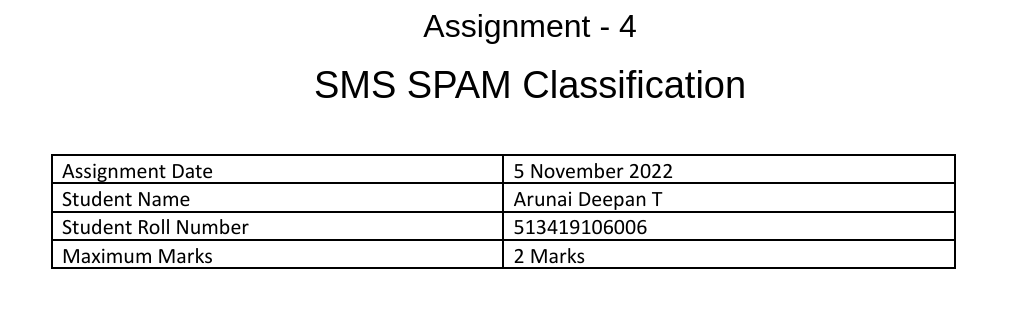



# Import required library


In [21]:
import numpy as np 
import pandas as pd 
import collections
import nltk
nltk.download('stopwords')
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Read dataset

In [2]:
dframe = pd.read_csv('/content/drive/MyDrive/IBM/spam.csv', encoding='ISO-8859-1')
dframe.shape

(5572, 5)

In [3]:
dframe.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data **Preprocessing**

In [4]:
print(f'Checking for columns having null values \n{dframe.isnull().any()}\n')
print(f'Checking for columns having only null values \n{dframe.isnull().all()}\n')
print(f'Total number of null values in all columns \n{dframe.isnull().sum()}\n')
print(dframe.shape)

Checking for columns having null values 
v1            False
v2            False
Unnamed: 2     True
Unnamed: 3     True
Unnamed: 4     True
dtype: bool

Checking for columns having only null values 
v1            False
v2            False
Unnamed: 2    False
Unnamed: 3    False
Unnamed: 4    False
dtype: bool

Total number of null values in all columns 
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

(5572, 5)


In [5]:
dframe = dframe.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"])


In [6]:
dframe.columns

Index(['v1', 'v2'], dtype='object')

In [7]:
dframe=dframe.rename({"v1":"category","v2":"messages"}, axis=1)

In [8]:
dframe

,category,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


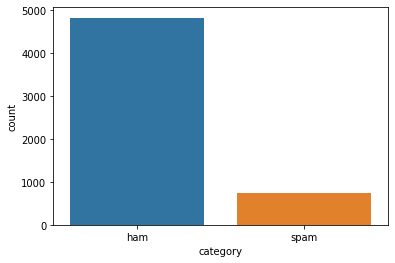

In [9]:
sns.countplot(dframe["category"])

In [12]:
dframe1 = dframe.copy()


In [13]:
dframe1 = dframe1.iloc[:,0:2]
dframe1.shape

(5572, 2)

In [14]:
dframe1.isnull().sum()

category    0
messages    0
dtype: int64

In [16]:
trainset_x = dframe1.iloc[:,1:2]
trainset_y = dframe1.iloc[:,0:1]
print(trainset_x)
print(trainset_y)

                                               messages
0     Go until jurong point, crazy.. Available only ...
1                         Ok lar... Joking wif u oni...
2     Free entry in 2 a wkly comp to win FA Cup fina...
3     U dun say so early hor... U c already then say...
4     Nah I don't think he goes to usf, he lives aro...
...                                                 ...
5567  This is the 2nd time we have tried 2 contact u...
5568              Will Ì_ b going to esplanade fr home?
5569  Pity, * was in mood for that. So...any other s...
5570  The guy did some bitching but I acted like i'd...
5571                         Rofl. Its true to its name

[5572 rows x 1 columns]
     category
0         ham
1         ham
2        spam
3         ham
4         ham
...       ...
5567     spam
5568      ham
5569      ham
5570      ham
5571      ham

[5572 rows x 1 columns]


# Create model

In [25]:
class SMSPreProcessor():
  
  def __init__(self,x,y):
    try:
      if len(x) == len(y):
        self.x = x
        self.y = y
        self.data = []
        self.ps = PorterStemmer()
        self.cv = CountVectorizer()
        self.re = re
        self.limit = self.x.shape[0]
    except:
      raise 'Given independent column - x  & dependent column - y   sizes are not matched'
    

  def sentenceProcess(self,string):
    v2 = str(string)
    v2 = self.re.sub('[^a-zA-Z]',' ',v2)
    v2 = v2.lower()
    v2 = v2.split()
    v2 = [self.ps.stem(word) for word in v2 if word not in set(stopwords.words('english'))]
    v2 = ' '.join(v2)
    return v2
  
  def sentenceUpdater(self):
    for i in range(0,self.limit):
      data = self.sentenceProcess(self.x.values[i])
      self.data.append(data)
  
  def trainProcess(self):
    self.x = self.cv.fit_transform(self.data).toarray()
    self.y = pd.get_dummies(self.y).drop('category_spam', axis=1)
  
  def xy_formater(self):
    self.sentenceUpdater()
    self.trainProcess()
    return self.x, self.y
  
  def test_process(self,string):
    string = self.sentenceProcess(string)
    string = self.cv.transform([string]).toarray()
    return string

# Preprocessing of dataset

In [26]:
processor = SMSPreProcessor(trainset_x, trainset_y)

xtrain, ytrain = processor.xy_formater()
print(xtrain)
print(ytrain)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
      category_ham
0                1
1                1
2                0
3                1
4                1
...            ...
5567             0
5568             1
5569             1
5570             1
5571             1

[5572 rows x 1 columns]


# Add Layers (LSTM, Dense-(Hidden Layers), Output)

In [27]:
lstm_model = Sequential()
lstm_model.add(Dense(1000, activation='relu'))
lstm_model.add(Dense(1500, activation='relu'))
lstm_model.add(Dense(3000, activation='relu'))
lstm_model.add(Dense(5000, activation='relu'))
lstm_model.add(Dense(500, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the Model

In [28]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the Model

In [30]:
lstm_model.fit(xtrain,ytrain,epochs=15)

Epoch 1/15
175/175 [==============================] - 45s 251ms/step - loss: 0.1301 - accuracy: 0.9648
Epoch 2/15
175/175 [==============================] - 44s 254ms/step - loss: 0.0102 - accuracy: 0.9971
Epoch 3/15
175/175 [==============================] - 44s 249ms/step - loss: 0.0058 - accuracy: 0.9982
Epoch 4/15
175/175 [==============================] - 43s 243ms/step - loss: 1.3064e-04 - accuracy: 1.0000
Epoch 5/15
175/175 [==============================] - 44s 252ms/step - loss: 9.9594e-08 - accuracy: 1.0000
Epoch 6/15
175/175 [==============================] - 43s 244ms/step - loss: 6.7322e-08 - accuracy: 1.0000
Epoch 7/15
175/175 [==============================] - 43s 244ms/step - loss: 5.7436e-08 - accuracy: 1.0000
Epoch 8/15
175/175 [==============================] - 43s 245ms/step - loss: 4.8369e-08 - accuracy: 1.0000
Epoch 9/15
175/175 [==============================] - 43s 244ms/step - loss: 4.1364e-08 - accuracy: 1.0000
Epoch 10/15
175/175 [============================

# Save The Model

In [31]:
lstm_model.save('sms.h5')

# Test The Model

In [33]:
sample_in = input('Enter the sms here : \n')
sms = processor.test_process(sample_in)
pred = lstm_model.predict(sms)
print(f'\nThe predicted binary output was : {pred[0][0]}')
print(f"\nThe SMS message is {'HAM' if pred>0.5 else 'SPAM'}")



Enter the sms here : 
how are you pal
1/1 [==============================] - 0s 53ms/step

The predicted binary output was : 1.0

The SMS message is HAM
